In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.nn.functional as F
import librosa
import numpy as np
from torch.nn.utils.rnn import pack_sequence, unpack_sequence
import matplotlib.pyplot as plt

import mfcc
import lane_detection

In [3]:
def convert_to_sec(s):
    times = list(reversed([int(x) for x in s.split(':')]))
    sec = times[0]
    for i, t in enumerate(times):
        sec += i * 60 * t

    return sec

def convert_times(t):
    s, e = [convert_to_sec(x) for x in t.split()]
    return (8 * s, 8 * e - 7)

In [4]:
import importlib
importlib.reload(mfcc)

winsize = 500
test1 = mfcc.get_mfcc('../wav/test1.wav', winsize)
test1 = mfcc.get_deltas(test1)
test2 = mfcc.get_mfcc('../wav/test2.wav', winsize)
test2 = mfcc.get_deltas(test2)

In [5]:
test1.shape

torch.Size([2173, 48])

In [6]:
import importlib
importlib.reload(lane_detection)

m = lane_detection.Model()
m.load_state_dict(torch.load('../lane.net'))

<All keys matched successfully>

In [7]:
def postprocess(x):
    x0 = torch.stack([x[i-2:i+3] for i in range(2, len(x) - 2)]).float()
    x0 = (torch.mean(x0, dim=1) > 0.5).long()
    return torch.cat([x[:2], x0, x[-2:]])

postprocess(torch.tensor([1, 0, 0, 1, 1]))

tensor([1, 0, 1, 1, 1])

torch.Size([89, 48])


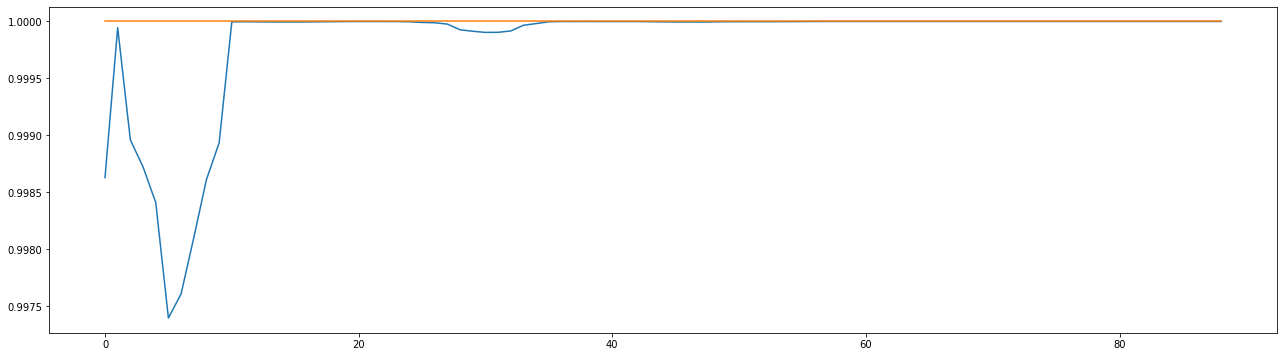

In [8]:
x = pack_sequence([test1[920:1009]], enforce_sorted=False).float()
print(test1[920:1009].shape)

m.eval()

with torch.no_grad():
    y = m(x)
    w = y[:, 1]
    z = postprocess(y.argmax(dim=1))

    
    plt.figure(figsize=(22, 6))
    plt.plot(w)
    plt.plot(z)

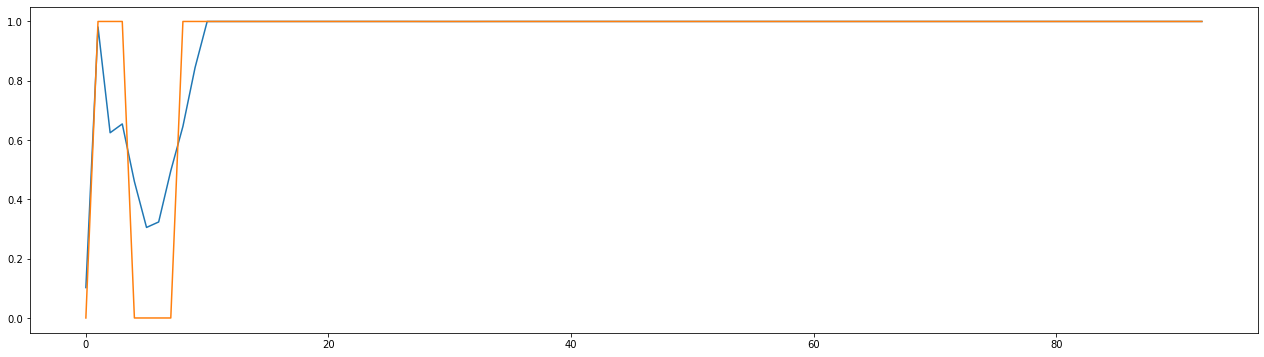

In [9]:
winsize = 500
seg = mfcc.get_mfcc('../out.wav', winsize)
seg = mfcc.get_deltas(seg)

x = pack_sequence([seg], enforce_sorted=False).float()

m.eval()

with torch.no_grad():
    y = m(x)
    w = y[:, 1]
    z = postprocess(y.argmax(dim=1))
    
    plt.figure(figsize=(22, 6))
    plt.plot(w)
    plt.plot(z)

[(0, 137), (1664, 1841), (1184, 1289)]
[(672, 809), (1448, 1577), (240, 481), (920, 1009), (1928, 2017)]


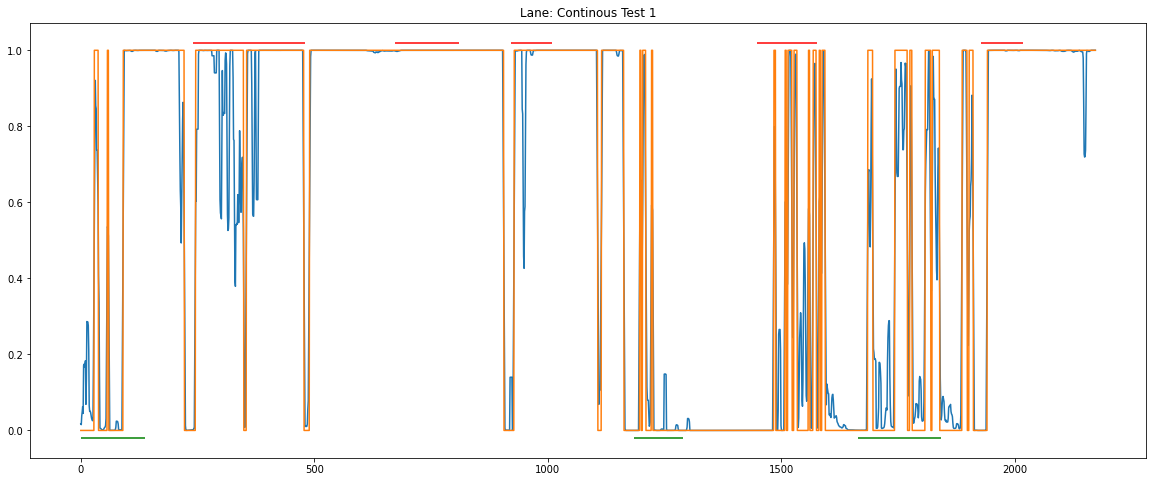

In [14]:
import importlib
importlib.reload(lane_detection)

m = lane_detection.Model()
m.load_state_dict(torch.load('../lane0.net'))

x = pack_sequence([test1], enforce_sorted=False).float()

r_nc = ['1:24 1:42', '3:01 3:18']
r_c = ['0:30 1:01', '1:55 2:07', '4:01 4:13']
l_nc = ['0:00 0:18', '3:28 3:51']
l_c = ['2:28 2:42']

right = r_nc + r_c
right = [convert_times(t) for t in right]

left = l_nc + l_c
left = [convert_times(t) for t in left]

print(left)
print(right)

m.eval()

with torch.no_grad():
    y = m(x)
    w = y[:, 1]
    z = y.argmax(dim=1)
    
    plt.figure(figsize=(20, 8))
    plt.plot(w)
    plt.plot(postprocess(z))
    
    plt.title('Lane: Continous Test 1')
    #plt.axhline(y=0.5, linestyle='--')

    for s, e in right:
        plt.hlines(y=1.02, xmin=s, xmax=e, colors='red')
        
    for s, e in left:
        plt.hlines(y=-0.02, xmin=s, xmax=e, colors='green')

[(1424, 1561), (1624, 1745), (576, 801)]
[(16, 169), (1200, 1329), (280, 409), (976, 1089), (1864, 1985)]


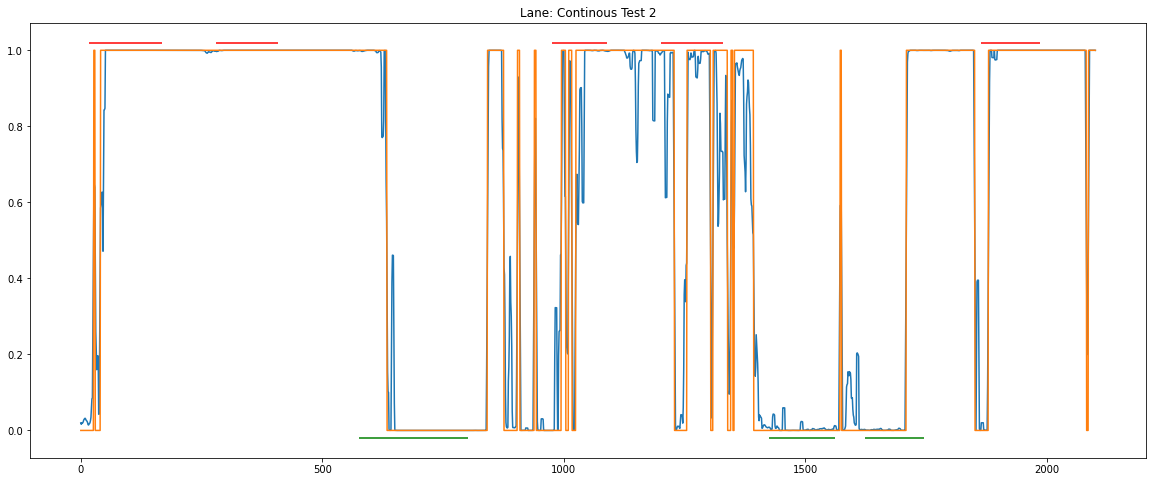

In [17]:
x = pack_sequence([test2], enforce_sorted=False).float()

r_nc = ['0:02 0:22', '2:30 2:47']
r_c = ['0:35 0:52', '2:02 2:17', '3:53 4:09']
l_nc = ['2:58 3:16', '3:23 3:39']
l_c = ['1:12 1:41']

right = r_nc + r_c
right = [convert_times(t) for t in right]

left = l_nc + l_c
left = [convert_times(t) for t in left]

print(left)
print(right)

m.eval()

with torch.no_grad():
    y = m(x)
    w = y[:, 1]
    z = y.argmax(dim=1)
    
    plt.figure(figsize=(20, 8))
    plt.plot(w)
    plt.plot(postprocess(z))
    
    plt.title('Lane: Continous Test 2')
    #plt.axhline(y=0.5, linestyle='--')

    for s, e in right:
        plt.hlines(y=1.02, xmin=s, xmax=e, colors='red')
        
    for s, e in left:
        plt.hlines(y=-0.02, xmin=s, xmax=e, colors='green')